In [1]:
from neuron import h, load_mechanisms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
h.load_file('stdrun.hoc')

1.0

In [3]:
##h.nrn_load_dll("nrnmech.dll")

In [ ]:
# Create a soma section
soma = h.Section(name='soma')
soma.L = 20     # Length of soma in µm
soma.diam = 20  # Diameter of soma in µm
soma.insert('pas')  # Passive properties for resting potential

# Attach Ligand to soma(0.5)
ligand = h.GenericLigand(soma(0.5))
ligand.decay_rate = 0.05
ligand.external_input = 0.01
ligand.C_init = 0.1

# Attach Receptor to soma(0.5)
receptor = h.GenericReceptor(soma(0.5))
receptor.capacity = 1.0
receptor.n_ligands = 1
receptor.kd1 = 100
receptor.efficacy1 = 0.3
receptor.decay1 = 0.1

# Attach NMDA to soma(0.5)
nmda = h.NMDA_Channel(soma(0.5))
nmda.gmax = 0.2
nmda.e = 0
nmda.mg = 0.1

# POINTER connection for ligand → receptor
h.setpointer(ligand._ref_C, 'C_lig1', receptor)

# POINTER connection for receptor → NMDA
h.setpointer(receptor._ref_activation, 'receptor_activation', nmda)

# Stimulus for ligand release
stim = h.NetStim()
stim.start = 10              # Start stimulus at 10 ms
stim.number = 5              # Fire 5 spikes
stim.interval = 10           # 10 ms between spikes

# Connect stimulus to ligand via NetCon (to trigger spikes)
nc1 = h.NetCon(stim, ligand)
nc1.weight[0] = 0.2          # Amount of ligand release

# Record data
t = h.Vector().record(h._ref_t)
ligand_conc = h.Vector().record(ligand._ref_C)
receptor_act = h.Vector().record(receptor._ref_activation)
nmda_current = h.Vector().record(nmda._ref_i)

In [25]:
h.tstop = 100
h.v_init = -65
h.dt = 0.025

In [26]:
h.finitialize(h.v_init)

1.0

In [27]:
h.continuerun(h.tstop)

0.0

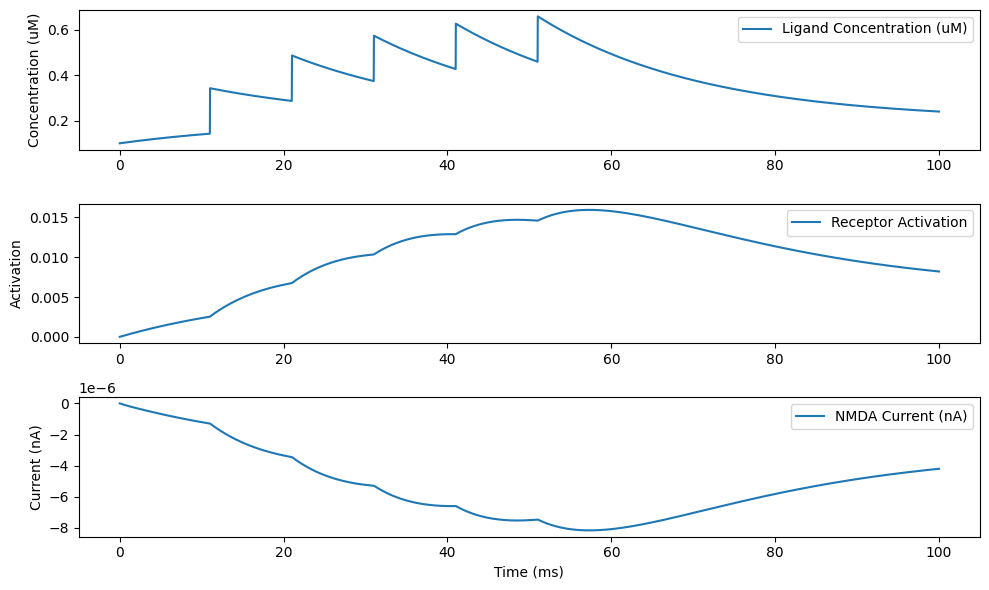

In [28]:
# Plot Results
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t, ligand_conc, label="Ligand Concentration (uM)")
plt.ylabel("Concentration (uM)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, receptor_act, label="Receptor Activation")
plt.ylabel("Activation")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, nmda_current, label="NMDA Current (nA)")
plt.xlabel("Time (ms)")
plt.ylabel("Current (nA)")
plt.legend()

plt.tight_layout()
plt.show()